In [1]:
import torch
from torch.nn.utils import clip_grad_value_
import matplotlib.pyplot as plt
# from transformers.models.gemma3.modeling_gemma3 import Gemma3TextScaledWordEmbedding
from functions import *
model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3-4b-pt-unsloth-bnb-4bit",
    max_seq_length = 8192, # Choose any for long context!
    load_in_4bit = True,
    resize_model_vocab=24,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 05-03 13:35:49 [__init__.py:239] Automatically detected platform cuda.
==((====))==  Unsloth 2025.4.3: Fast Gemma3 patching. Transformers: 4.51.3. vLLM: 0.8.2.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.642 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
model.config.image_token_index = 16 # new image token
model.language_model.lm_head.weight.requires_grad_(True);
model.language_model.model.embed_tokens.padding_idx = None
# model.language_model.lm_head.load_state_dict(torch.load("/home/zhenlan/Desktop/Projects/ARC2/Model/gemma24.pth"))
model.language_model.lm_head.load_state_dict(torch.load("../../Model/lm_heads_weights_VLM2.pth"))

<All keys matched successfully>

In [3]:
import json
output_path = '/home/zhenlan/Desktop/Projects/ARC2/Data/ARC-AGI-2-main/combined_data.json'
with open(output_path, 'r') as f:
    data = json.load(f)

In [4]:
model = PeftModel.from_pretrained(model, "../../Model/merged_model_VLM2", is_trainable=True)

In [5]:
inputs_f, y_f = next(iter(data_gen_VLM(data, False, tokenizer, 3, False)))

In [6]:
# hack to get mask back:
# self.causal_mask = causal_mask in Gemma3TextModel line 691
model.eval();
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
        masks = model(**inputs_f)

In [7]:
causal_mask = model.base_model.language_model.model.causal_mask

In [8]:
causal_mask.shape,inputs_f['input_ids'][0].shape, inputs_f['attention_mask'].shape

(torch.Size([1, 1, 4758, 4758]),
 torch.Size([4758]),
 torch.Size([1, 1, 4758, 4758]))

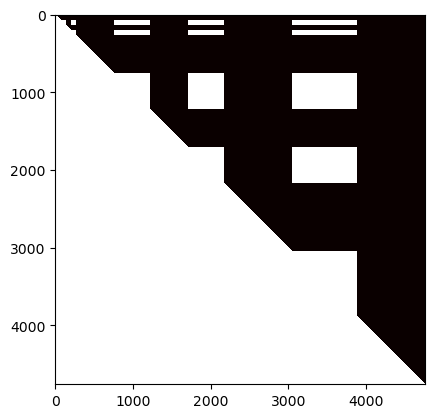

In [26]:
plt.imshow(causal_mask[0,0].float().cpu().numpy(), cmap='hot', interpolation='nearest')

In [28]:
causal_mask[0,0]

tensor([[ 0.0000e+00, -3.3895e+38, -3.3895e+38,  ..., -3.3895e+38,
         -3.3895e+38, -3.3895e+38],
        [ 0.0000e+00,  0.0000e+00, -3.3895e+38,  ..., -3.3895e+38,
         -3.3895e+38, -3.3895e+38],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.3895e+38,
         -3.3895e+38, -3.3895e+38],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -3.3895e+38, -3.3895e+38],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -3.3895e+38],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0', dtype=torch.bfloat16)

In [33]:
import numpy as np

def create_attention_mask(length: int) -> np.ndarray:
  """
  Creates a square attention mask for a sequence of a given length.

  The mask has the following properties:
  - Lower triangular elements (below the main diagonal) are 0.
  - Diagonal elements are 0.
  - Upper triangular elements (above the main diagonal) are -infinity.

  This type of mask is often used in causal attention mechanisms (like in decoder-only
  transformers) where a position should only attend to previous positions and itself,
  but here we explicitly zero out the diagonal as well, meaning a position cannot
  attend to itself either, only strictly previous positions. If self-attention is
  desired, the diagonal should also be 0.

  Args:
    length: The sequence length, which determines the dimensions of the mask (length x length).

  Returns:
    A numpy array of shape (length, length) with the specified mask values (float dtype).
  """
  # Start with a mask of all zeros. This covers the diagonal and lower triangle.
  # Use a float dtype to accommodate -infinity.
  mask = np.zeros((length, length), dtype=np.float32)

  # Get the indices for the upper triangle, *excluding* the main diagonal (k=1).
  # For i < j
  upper_indices = np.triu_indices(length, k=1)

  # Set the upper triangular part to negative infinity.
  mask[upper_indices] = -np.inf

  return mask

In [ ]:
# lower triangular and diagonal zero and upper triangular -inf
inputs_f['attention_mask'] = torch.tensor(create_attention_mask(inputs_f['input_ids'].shape[1]), device=inputs_f['input_ids'].device)\
                                    .unsqueeze(0).unsqueeze(0)

In [42]:
# hack to get mask back:
# self.causal_mask = causal_mask in Gemma3TextModel line 691
model.eval();
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
        masks = model(**inputs_f)

In [43]:
causal_mask = model.base_model.language_model.model.causal_mask

In [46]:
causal_mask[0,0].dtype

torch.float32

In [47]:
causal_mask[0,0]

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

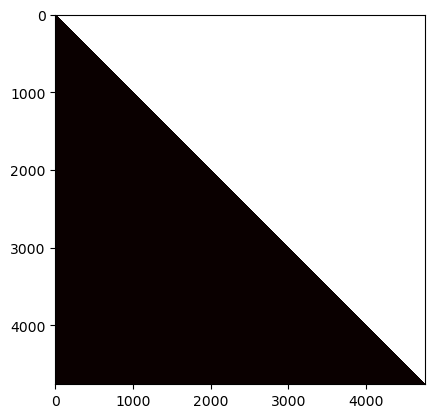

In [44]:
plt.imshow(causal_mask[0,0].float().cpu().numpy(), cmap='hot', interpolation='nearest')